# Mount the Notebook with Google drive. It is not neccesery if we use local machine

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Python libraries


In [54]:
import pandas as pd
from scipy.io import wavfile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, lfilter, freqz
import librosa
import librosa.display

Creating a butter worth band pass filter with a lower cutoff, higher cutoff and order of the filter (deafault order is 5)

In [55]:
#This function create the denominator and numerator coefficient of the Band pass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

#This create the band pass filter with those coefficients
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

#Effect of Band pass filter

In [56]:
d,r = librosa.load(r"/content/drive/My Drive/heart/Atraining_normal/201101070538.wav")
y = butter_bandpass_filter(d, lowcut = 2, highcut = 195,fs=r, order=2)

#Time domain visualization

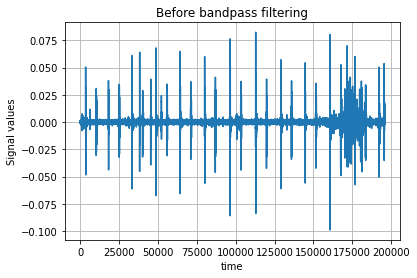

In [57]:
plt.plot(d)
plt.xlabel("time")
plt.ylabel("Signal values")
plt.title("Before bandpass filtering")
plt.grid("on")

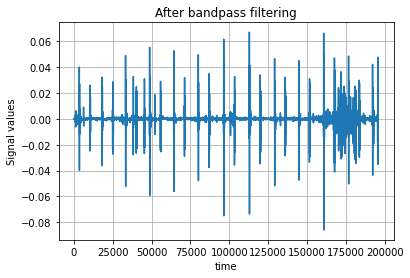

In [58]:
plt.plot(y)
plt.xlabel("time")
plt.ylabel("Signal values")
plt.title("After bandpass filtering")
plt.grid("on")

#Frequency domain visualization MFCC plot

#Before filtering

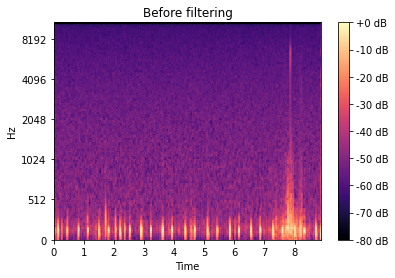

In [59]:
S = librosa.feature.melspectrogram(d, sr=r, n_fft = 2048, hop_length=512, n_mels=128)
S_DB = librosa.power_to_db(S, ref=np.max)

fig = plt.Figure()
p = librosa.display.specshow(S_DB, sr=r, hop_length= 512, x_axis='time', y_axis='mel')
plt.title("Before filtering")
plt.colorbar(format='%+2.0f dB');

#After filtering

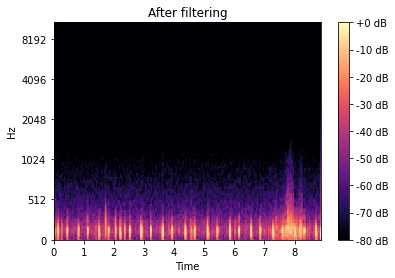

In [60]:
S = librosa.feature.melspectrogram(y, sr=r, n_fft = 2048, hop_length=512, n_mels=128)
S_DB = librosa.power_to_db(S, ref=np.max)

fig = plt.Figure()
p = librosa.display.specshow(S_DB, sr=r, hop_length= 512, x_axis='time', y_axis='mel')
plt.title("After filtering")
plt.colorbar(format='%+2.0f dB');

# Read csv related to normal heart sounds

In [61]:
p1 = r"/content/drive/My Drive/heart/Atraining_normal/"
p2 = r"/content/drive/My Drive/heart//Training B Normal//"

#Set A normal dataset
dfa = pd.read_csv(r"/content/drive/My Drive/heart/Atraining_normal_seg.csv")

#Set B normal dataset
dfb = pd.read_csv(r"/content/drive/My Drive/heart/Btraining_normal_seg.csv")

In [62]:
#check the shape of the csvs
dfa.shape,dfb.shape

((21, 39), (90, 61))

# Modify the 1st column, add proper path in 1st column



In [63]:
#for set A
for i in range(dfa.shape[0]):
    dfa.iloc[i,0] = p1 + dfa.iloc[i,0][:-3] + "wav"

#for set B
for i in range(dfb.shape[0]):

    dfb.iloc[i,0] = p2 + dfb.iloc[i,0][:-4] + "wav"

# Check modified first column. Now We can read the audio files with this path

In [64]:
dfa.iloc[0,0]

'/content/drive/My Drive/heart/Atraining_normal/201102081321.wav'

# Creating the labels i.e no of heart beats present in that sound
# We count no of s1 and s2 present for each wav file that is our labels
 There is some vaccant cell in the csvs. Pandas treats those as "NAN", so we use df.count() to count proper heart beats with out "NAN" values

In [65]:

labels = []
#for set A
for i in range(dfa.shape[0]):

    d,r = librosa.load(dfa.iloc[i,0])    
    name = dfa.iloc[i,-1]
    
    s = pd.DataFrame(dfa.iloc[i,1:-1])
    labels.append(int(s.count()))
    
#for set B
for i in range(dfb.shape[0]):

    d,r = librosa.load(dfb.iloc[i,0])   
    name = dfb.iloc[i,-1]
                  
    s = pd.DataFrame(dfb.iloc[i,1:-1])
    labels.append(int(s.count()))

In [66]:
#Save those labels as numpy array
#np.save(r"C:\Users\user\Desktop\heart sound\numpy labels and specto\labels.npy",labels)

## Determined maximum length of the wav file. Later we use this no for zero padding of our audio files



In [67]:
max_len = 0

for i in range(dfa.shape[0]):

    d,r = librosa.load(dfa.iloc[i,0])    
    if max_len < len(list(d)):
        max_len = len(list(d))
    
for i in range(dfb.shape[0]):

    d,r = librosa.load(dfb.iloc[i,0])                      
    if max_len < len(list(d)):
        max_len = len(list(d))

#print maximum length      
print(max_len)

323694


# For feature extraction we use 25 MFCC coefficients in log scale [MFCC documentation](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)

In [68]:
# calculate mfcc using librosa
def calculatemfcc(d):
    mfccs = librosa.feature.mfcc(y=np.array(d,dtype=float), sr=r, n_mfcc=25)
    mfccs_db = librosa.power_to_db(mfccs, ref=np.max)
    return mfccs_db

# In this project we worked two different heart beats dataset.
1. [Challenge dataset](https://http://www.peterjbentley.com/heartchallenge/)
2. Dataset provided by Organization

In [69]:
df = pd.read_csv(r'/content/drive/My Drive/heart/tenseconds/beatscount(modified).csv')
df["predicted"] = 0

# Creating feature data 
Load wav file -> use band pass filetring -> calculate mfccs -> dump in a list

Then create a list of list


In [70]:
x_wav = []

for i in range(dfa.shape[0]):

    d,r = librosa.load(dfa.iloc[i,0])    
    d = list(d)
    
    if len(d) < max_len:
        for i in range(max_len-len(d)):
            d.append(0)
            
    value = butter_bandpass_filter(d, lowcut = 2, highcut = 195,fs=r, order=2) 
    
    x_wav.append(calculatemfcc(value))
    
for i in range(dfb.shape[0]):

    d,r = librosa.load(dfb.iloc[i,0])  
   # print(r)
    d = list(d)
    
    if len(d) < max_len:
        for i in range(max_len-len(d)):
            d.append(0)
            
    value = butter_bandpass_filter(d, lowcut = 2, highcut = 195,fs=r, order=2)
    
    x_wav.append(calculatemfcc(value))

In [71]:
# create an feature data array
x_wav = np.array(x_wav)
# reshape the array
x_wav = x_wav.reshape(x_wav.shape[0],x_wav.shape[1]*x_wav.shape[2])

In [72]:
x_wav.shape

(111, 15825)

#Save the feature array as Numpy array

In [73]:
np.save(r"C:\Users\user\Desktop\heart sound\numpy labels and specto\x_wav.npy",x_wav)

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc,roc_curve,classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

#Normalize the given data
We used [MinMax Normalization](https:en.wikipedia.org/wiki/Normalization_(statistics))

In [75]:
scaler = MinMaxScaler()
x_wav = scaler.fit_transform(x_wav)

#Split the dataset ito training and testing set with training size 90% of the total dataset

In [76]:
X_train, X_test,y_train, y_test = train_test_split(x_wav, labels, shuffle = True,train_size=0.9, random_state=0)

In [77]:
X_train.shape,X_test.shape

((99, 15825), (12, 15825))

In [78]:
import xgboost as xgb

#Define XGBOOST regressor

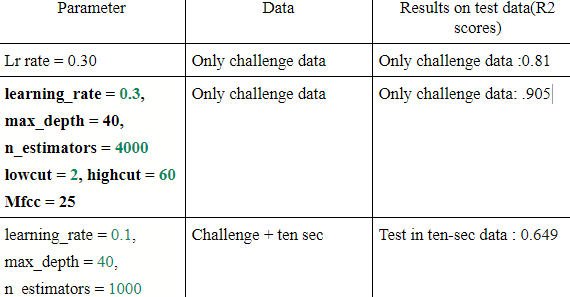

In [79]:
#define xgb
classifier = xgb.XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 40, alpha = 10, n_estimators = 3000)
#train xgb
classifier.fit(X_train, y_train)

#predict on test set
y_pred = classifier.predict(X_test)

[16:54:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [80]:
from sklearn.metrics import r2_score

#Calculate [R2 score](https://en.wikipedia.org/wiki/Coefficient_of_determination)

In [81]:
r2_score(y_test, y_pred)

0.7515382483417745

#Calculate [Root mean squared error](https://en.wikipedia.org/wiki/Root-mean-square_deviation)

In [82]:
from sklearn.metrics import mean_squared_error

from math import sqrt

rmse = sqrt(mean_squared_error(y_test, y_pred))

print(rmse)

5.573409660501465


###Predict the whole dataset with the XGB regressor model to test whether our model performed well or not

In [83]:
y_pred = classifier.predict(x_wav)

#Calculate the R2 Score for this time also

In [84]:
y_pred.shape,r2_score(labels, y_pred)

((111,), 0.9648613352493507)

#Visualization of our predicted vs actual heart beats using Bar plot

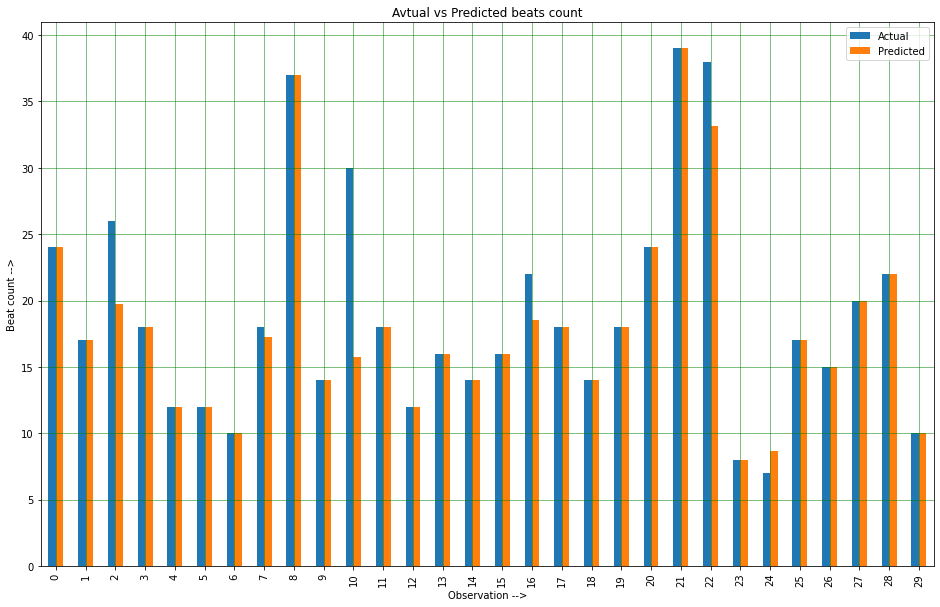

In [85]:
df_repre = pd.DataFrame({'Actual': labels, 'Predicted': y_pred.flatten()})
df1 = df_repre.head(30)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.ylabel("Beat count -->")
plt.xlabel("Observation -->")
plt.title("Avtual vs Predicted beats count")
plt.show()

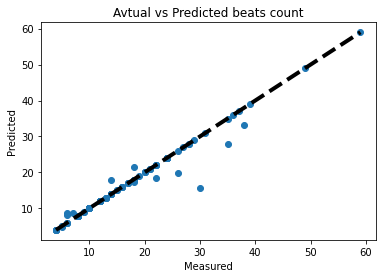

In [86]:
fig, ax = plt.subplots()
ax.scatter(labels, y_pred)
ax.plot([min(labels), max(labels)], [min(labels), max(labels)], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title("Avtual vs Predicted beats count")
plt.show()

##Here we used two datasets.
For second dataset (which is provided by organization) we just need to change x_wav and labels files.

In [87]:
df = pd.read_csv(r"/content/drive/My Drive/heart/tenseconds/beatscount(modified).csv")
df['predicted'] = 0

In [88]:
labels = np.array(df['Beats (Audio)'])

Load wav file -> use band pass filetring -> calculate mfccs -> dump in a list

Then create a list of list

In [89]:

x_wav = []

for i in range(df.shape[0]):
    
    d,r = librosa.load(r"/content/drive/My Drive/heart/tenseconds/Ten Seconds/" + df.iloc[i,1] +  ".wav")
    d = list(d)
    
    #print((r))
    
    if len(d) < max_len:
        for i in range(max_len-len(d)):
            d.append(0)
            
    value = butter_bandpass_filter(d, lowcut = 2, highcut = 195,fs=r, order=2)
    
    x_wav.append(calculatemfcc(value))